In [ ]:
import utils

import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import metrics

### First model - Naive Bayes

### Data import and train - test split

In [2]:
folder_path = '../datasets/20_newsgroups'

X, y, target_names = utils.load_data_from_folder(folder_path)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Model training

In [ ]:
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

### Metrics

In [7]:
y_pred = clf.predict(X_test_tfidf)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

                          precision    recall  f1-score   support

             alt.atheism       0.76      0.84      0.80       173
           comp.graphics       0.81      0.83      0.82       179
 comp.os.ms-windows.misc       0.92      0.92      0.92       226
comp.sys.ibm.pc.hardware       0.81      0.89      0.85       204
   comp.sys.mac.hardware       0.94      0.93      0.93       205
          comp.windows.x       0.92      0.85      0.89       186
            misc.forsale       0.91      0.86      0.88       190
               rec.autos       0.92      0.92      0.92       203
         rec.motorcycles       0.97      0.93      0.95       218
      rec.sport.baseball       0.95      0.93      0.94       192
        rec.sport.hockey       0.93      0.97      0.95       203
               sci.crypt       0.94      0.97      0.96       200
         sci.electronics       0.95      0.84      0.89       227
                 sci.med       0.99      0.93      0.96       196
         

### The confusion matrix

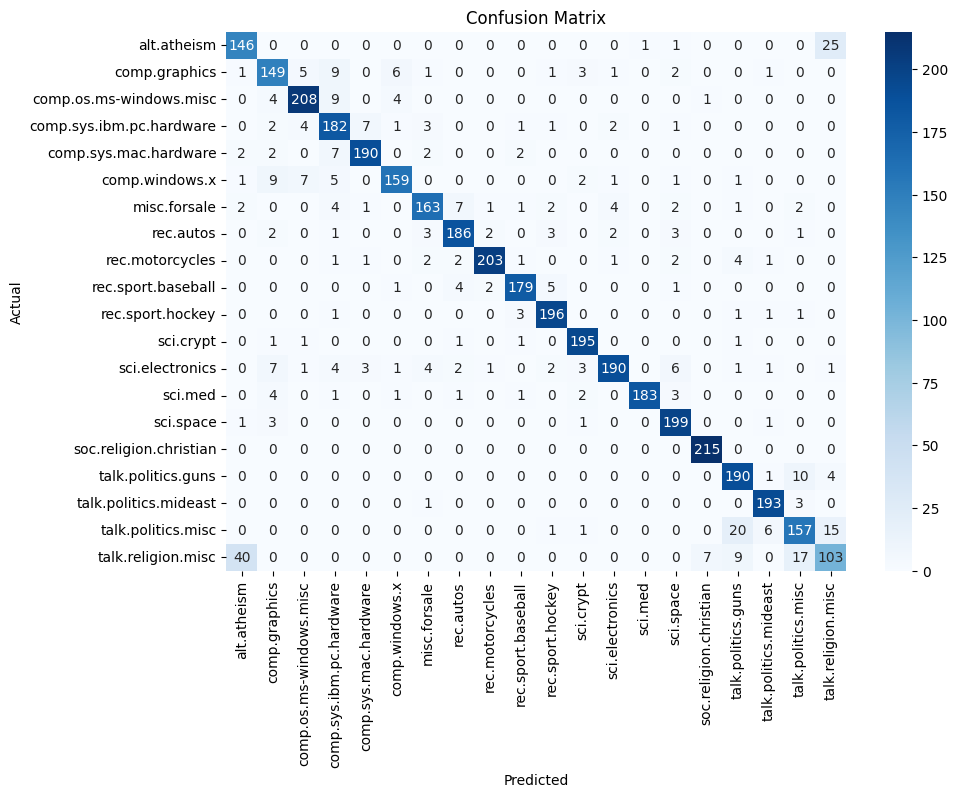

In [8]:
conf_mat = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, 
            yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_path = 'naive_bayes_model.pkl'
joblib.dump(clf, model_path)

vectorizer_path = 'tfidf_vectorizer.pkl'
joblib.dump(vectorizer, vectorizer_path)

### Second model - RNN

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

### Data import and train - test split

In [3]:
folder_path = '../datasets/20_newsgroups'

X, y, target_names = utils.RNN_load_data_from_folder(folder_path)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Tokenization

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)


tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

with open('tokenizer.pkl', 'wb') as f:
    joblib.dump(tokenizer, f)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [15]:
max_sequence_length = 1000
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

### Converting into Numpy arrays

In [16]:
X_train_pad = np.array(X_train_pad)
X_test_pad = np.array(X_test_pad)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(len(target_names), activation='softmax')
])

In [18]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=4, 
                               mode='min', 
                               verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=3, 
                              min_lr=0.001, 
                              mode='min', 
                              verbose=1)

callbacks = [early_stopping, reduce_lr]

### Model training

In [19]:
history = model.fit(X_train_pad, y_train, epochs=6, batch_size=64, validation_data=(X_test_pad, y_test), callbacks=callbacks)

Epoch 1/6


2024-06-05 05:50:25.688459: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 63988000 exceeds 10% of free system memory.
2024-06-05 05:50:26.343690: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 41101824 exceeds 10% of free system memory.


250/250 [==============================] - 199s 791ms/step - loss: 2.6626 - accuracy: 0.1548 - val_loss: 2.3343 - val_accuracy: 0.2733 - lr: 0.0010
Epoch 2/6
250/250 [==============================] - 193s 774ms/step - loss: 1.9421 - accuracy: 0.4020 - val_loss: 1.7899 - val_accuracy: 0.4185 - lr: 0.0010
Epoch 3/6
250/250 [==============================] - 195s 779ms/step - loss: 1.2434 - accuracy: 0.6260 - val_loss: 1.3161 - val_accuracy: 0.5620 - lr: 0.0010
Epoch 4/6
250/250 [==============================] - 193s 771ms/step - loss: 1.0928 - accuracy: 0.6959 - val_loss: 1.3537 - val_accuracy: 0.5888 - lr: 0.0010
Epoch 5/6
250/250 [==============================] - 195s 779ms/step - loss: 0.5253 - accuracy: 0.8518 - val_loss: 1.1858 - val_accuracy: 0.6503 - lr: 0.0010
Epoch 6/6
250/250 [==============================] - 194s 776ms/step - loss: 0.4449 - accuracy: 0.8725 - val_loss: 1.6249 - val_accuracy: 0.5415 - lr: 0.0010


In [21]:
model.save('RNN_classification_model.h5')
best_model = tf.keras.models.load_model('RNN_classification_model.h5')


loss, accuracy = best_model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {accuracy}')

125/125 [==============================] - 14s 107ms/step - loss: 1.6249 - accuracy: 0.5415
Test Accuracy: 0.5414999723434448


### Evaluation

In [53]:
y_pred = np.argmax(model.predict(X_test_pad), axis=-1)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

125/125 [==============================] - 18s 140ms/step
                          precision    recall  f1-score   support

             alt.atheism       0.69      0.58      0.63       173
           comp.graphics       0.50      0.60      0.55       179
 comp.os.ms-windows.misc       0.60      0.66      0.63       226
comp.sys.ibm.pc.hardware       0.64      0.60      0.62       204
   comp.sys.mac.hardware       0.72      0.74      0.73       205
          comp.windows.x       0.81      0.62      0.70       186
            misc.forsale       0.76      0.77      0.76       190
               rec.autos       0.73      0.76      0.75       203
         rec.motorcycles       0.90      0.80      0.85       218
      rec.sport.baseball       0.84      0.93      0.88       192
        rec.sport.hockey       0.97      0.82      0.89       203
               sci.crypt       0.85      0.78      0.81       200
         sci.electronics       0.58      0.61      0.60       227
                 

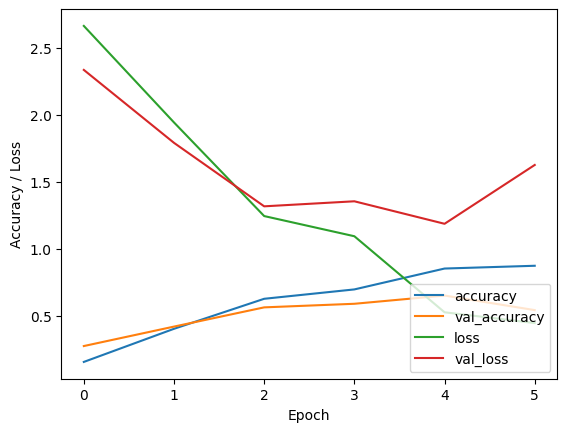

In [22]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.legend(loc='lower right')
plt.show()